In [ ]:
pip install pydicom nibabel numpy torch torchvision segmentation-models-pytorch scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import pandas as pd
import random
import segmentation_models_pytorch as smp
import torch.optim as optim
import torch.nn as nn
from scipy.ndimage import zoom
from operator import itemgetter
from sklearn.metrics import jaccard_score

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_classes = 9
batch_size = 8
img_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Images"
mask_root = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/Annotations"
metadata_path = "/home/ealam/JHIR_Hip_Knee_Datasets/Knee/segmentation_with_racegender.csv"
test_augmentations = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(mean=(0.485,), std=(0.229,)),
    ToTensorV2(),
])

class MulticlassHipSegmentationDataset(Dataset):
    def __init__(self, img_root, mask_root, metadata_df, paired_files, num_classes, transforms=None, preprocessing=None):
        self.img_root = img_root
        self.mask_root = mask_root
        self.metadata_df = metadata_df
        self.paired_files = paired_files
        self.num_classes = num_classes
        self.transforms = transforms
        self.preprocessing = preprocessing

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        image_file, mask_file = self.paired_files[idx]
        if not os.path.exists(os.path.join(self.mask_root, mask_file)):
            return None

        dicom_image = pydicom.dcmread(os.path.join(self.img_root, image_file))
        image = dicom_image.pixel_array.astype(np.float32)
        annotation = nib.load(os.path.join(self.mask_root, mask_file))
        annotation_data = annotation.get_fdata()
        if len(annotation_data.shape) == 3:
            annotation_data = annotation_data[:, :, 0]

        annotation_data = self.calculate_flipped_rotated_mask(annotation_data)

        if annotation_data.ndim > 2 and annotation_data.shape[-1] != 1:
            raise ValueError('Mask has multiple channels')

        if image.shape != annotation_data.shape:
            zoom_factors = np.array(image.shape) / np.array(annotation_data.shape)
            annotation_data = zoom(annotation_data, zoom_factors, order=0)

        if self.transforms is not None:
            transformed = self.transforms(image=image, mask=annotation_data)
            image = transformed["image"]
            annotation_data = transformed["mask"]

        annotation_data_onehot = self.one_hot_encode(annotation_data)

        if self.preprocessing is not None:
            transformed = self.preprocessing(image=image, mask=annotation_data_onehot)
            image = transformed["image"]
            annotation_data_onehot = transformed["mask"]

        patient_id = int(float(image_file.split(".")[0]))
        racegender_info = self.metadata_df.loc[self.metadata_df['id'] == patient_id]['racegender'].values
        racegender = racegender_info[0] if racegender_info else 'Unknown'

        return image, annotation_data_onehot, racegender

    def one_hot_encode(self, mask):
        one_hot_mask = np.zeros((self.num_classes, *mask.shape), dtype=np.float32)
        for class_idx in range(self.num_classes):
            one_hot_mask[class_idx][mask == class_idx] = 1.0
        return one_hot_mask

    def calculate_flipped_rotated_mask(self, mask):
        rotated_mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        flipped_rotated_mask = cv2.flip(rotated_mask, 1)
        return flipped_rotated_mask

metadata_df = pd.read_csv(metadata_path)

image_files = sorted(os.listdir(img_root))
mask_files = sorted(os.listdir(mask_root))

paired_files = []

for image_file in image_files:
    image_id = os.path.splitext(image_file)[0]
    mask_file = f"{image_id}.nii.gz"
    if mask_file in mask_files:
        paired_files.append((image_file, mask_file))

random.shuffle(paired_files)

train_size = int(0.7 * len(paired_files))
valid_size = int(0.1 * len(paired_files))
test_size = len(paired_files) - train_size - valid_size

train_pairs = paired_files[:train_size]
valid_pairs = paired_files[train_size:train_size + valid_size]
test_pairs = paired_files[train_size + valid_size:]

train_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, train_pairs, num_classes,
    transforms=test_augmentations
)

model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=1,
    classes=num_classes,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

valid_set = MulticlassHipSegmentationDataset(
    img_root, mask_root, metadata_df, valid_pairs, num_classes,
    transforms=test_augmentations
)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2)

num_epochs = 100


for epoch in range(num_epochs):
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    model.train()

    iou_racegender_list = []

    for batch_idx, (images, masks, racegender) in enumerate(train_loader):
        if images is None:
            continue

        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)
        loss = criterion(outputs, masks.argmax(dim=1))
        loss.backward()
        optimizer.step()

        train_iou = jaccard_score(
            masks.argmax(dim=1).cpu().numpy().flatten(),
            predicted_masks.cpu().numpy().flatten(),
            average='micro'
        )
        iou_racegender_list.append((train_iou, batch_idx, racegender))

    if epoch > 2:
        # Sort the list of IoU values, indices, and racegender in descending order based on IoU values
        iou_racegender_list.sort(reverse=True, key=itemgetter(0))

        # Extract unique racegenders
        racegenders = set(racegender for _, _, racegender in iou_racegender_list)

        # Create dictionaries to store sorted lists of IoU values and indices for each racegender
        racegender_lists = {racegender: [] for racegender in racegenders}
        for iou, idx, racegender in iou_racegender_list:
            racegender_lists[racegender].append((iou, idx))

        # Reconstruct DataLoader based on sorted indices and alternating racegenders
        sorted_indices = []
        for racegender in racegenders:
            sorted_indices.extend([idx for _, idx in racegender_lists[racegender]])

        train_loader = DataLoader(
            train_set,
            batch_size=batch_size,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(sorted_indices),
            num_workers=2
        )

    model.eval()
    valid_iou_list = []

    for batch_idx, (images, masks, racegender) in enumerate(valid_loader):
        images, masks = images.to(device), masks.to(device)
        with torch.no_grad():
            outputs = model(images)
        predicted_masks = torch.argmax(outputs, dim=1)

        valid_iou = jaccard_score(
            masks.argmax(dim=1).cpu().numpy().flatten(),
            predicted_masks.cpu().numpy().flatten(),
            average='micro'
        )

        valid_iou_list.append(valid_iou)

    valid_iou_avg = np.mean(valid_iou_list)

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train IoU: {train_iou:.4f} - Validation IoU: {valid_iou_avg:.4f}")

/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [1/100] - Train IoU: 0.0435 - Validation IoU: 0.0700


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [2/100] - Train IoU: 0.0583 - Validation IoU: 0.0492


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [3/100] - Train IoU: 0.0852 - Validation IoU: 0.0393


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [4/100] - Train IoU: 0.1080 - Validation IoU: 0.0515


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [5/100] - Train IoU: 0.1492 - Validation IoU: 0.0707


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [6/100] - Train IoU: 0.1678 - Validation IoU: 0.1100


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [7/100] - Train IoU: 0.2126 - Validation IoU: 0.1592


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [8/100] - Train IoU: 0.2405 - Validation IoU: 0.2074


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [9/100] - Train IoU: 0.2916 - Validation IoU: 0.2561


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [10/100] - Train IoU: 0.2950 - Validation IoU: 0.3107


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [11/100] - Train IoU: 0.3605 - Validation IoU: 0.3626


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [12/100] - Train IoU: 0.4038 - Validation IoU: 0.4122


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [13/100] - Train IoU: 0.4363 - Validation IoU: 0.4618


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [14/100] - Train IoU: 0.4567 - Validation IoU: 0.5047


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [15/100] - Train IoU: 0.5071 - Validation IoU: 0.5402


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [16/100] - Train IoU: 0.5338 - Validation IoU: 0.5684


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [17/100] - Train IoU: 0.5422 - Validation IoU: 0.5926


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [18/100] - Train IoU: 0.5608 - Validation IoU: 0.6118


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [19/100] - Train IoU: 0.5923 - Validation IoU: 0.6268


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [20/100] - Train IoU: 0.6121 - Validation IoU: 0.6375


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [21/100] - Train IoU: 0.6268 - Validation IoU: 0.6506


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [22/100] - Train IoU: 0.6427 - Validation IoU: 0.6629


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [23/100] - Train IoU: 0.6574 - Validation IoU: 0.6729


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [24/100] - Train IoU: 0.6649 - Validation IoU: 0.6826


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [25/100] - Train IoU: 0.7005 - Validation IoU: 0.6944


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [26/100] - Train IoU: 0.6804 - Validation IoU: 0.7004


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [27/100] - Train IoU: 0.7136 - Validation IoU: 0.7045


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [28/100] - Train IoU: 0.7046 - Validation IoU: 0.7071


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [29/100] - Train IoU: 0.7144 - Validation IoU: 0.7094


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [30/100] - Train IoU: 0.7420 - Validation IoU: 0.7153


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [31/100] - Train IoU: 0.7553 - Validation IoU: 0.7225


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [32/100] - Train IoU: 0.7607 - Validation IoU: 0.7298


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [33/100] - Train IoU: 0.7863 - Validation IoU: 0.7361


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [34/100] - Train IoU: 0.7898 - Validation IoU: 0.7405


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [35/100] - Train IoU: 0.7790 - Validation IoU: 0.7439


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [36/100] - Train IoU: 0.8016 - Validation IoU: 0.7447


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [37/100] - Train IoU: 0.8142 - Validation IoU: 0.7478


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [38/100] - Train IoU: 0.8300 - Validation IoU: 0.7584


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [39/100] - Train IoU: 0.8334 - Validation IoU: 0.7666


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [40/100] - Train IoU: 0.8425 - Validation IoU: 0.7688


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [41/100] - Train IoU: 0.8485 - Validation IoU: 0.7722


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [42/100] - Train IoU: 0.8434 - Validation IoU: 0.7763


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [43/100] - Train IoU: 0.8639 - Validation IoU: 0.7858


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [44/100] - Train IoU: 0.8820 - Validation IoU: 0.7882


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [45/100] - Train IoU: 0.8751 - Validation IoU: 0.7887


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [46/100] - Train IoU: 0.8860 - Validation IoU: 0.7953


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [47/100] - Train IoU: 0.8816 - Validation IoU: 0.8027


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [48/100] - Train IoU: 0.8866 - Validation IoU: 0.8080


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [49/100] - Train IoU: 0.8896 - Validation IoU: 0.8135


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [50/100] - Train IoU: 0.8871 - Validation IoU: 0.8165


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [51/100] - Train IoU: 0.8886 - Validation IoU: 0.8192


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [52/100] - Train IoU: 0.8892 - Validation IoU: 0.8179


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [53/100] - Train IoU: 0.8950 - Validation IoU: 0.8174


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [54/100] - Train IoU: 0.8920 - Validation IoU: 0.8196


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [55/100] - Train IoU: 0.9082 - Validation IoU: 0.8224


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [56/100] - Train IoU: 0.9121 - Validation IoU: 0.8255


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [57/100] - Train IoU: 0.9040 - Validation IoU: 0.8289


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [58/100] - Train IoU: 0.9237 - Validation IoU: 0.8313


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [59/100] - Train IoU: 0.9226 - Validation IoU: 0.8317


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [60/100] - Train IoU: 0.9262 - Validation IoU: 0.8364


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [61/100] - Train IoU: 0.9319 - Validation IoU: 0.8399


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [62/100] - Train IoU: 0.9323 - Validation IoU: 0.8387


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [63/100] - Train IoU: 0.9203 - Validation IoU: 0.8391


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [64/100] - Train IoU: 0.9187 - Validation IoU: 0.8403


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [65/100] - Train IoU: 0.9331 - Validation IoU: 0.8424


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [66/100] - Train IoU: 0.9246 - Validation IoU: 0.8430


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [67/100] - Train IoU: 0.9313 - Validation IoU: 0.8448


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [68/100] - Train IoU: 0.9414 - Validation IoU: 0.8420


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [69/100] - Train IoU: 0.9433 - Validation IoU: 0.8451


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [70/100] - Train IoU: 0.9422 - Validation IoU: 0.8507


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [71/100] - Train IoU: 0.9457 - Validation IoU: 0.8489


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [72/100] - Train IoU: 0.9329 - Validation IoU: 0.8487


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [73/100] - Train IoU: 0.9525 - Validation IoU: 0.8534


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [74/100] - Train IoU: 0.9493 - Validation IoU: 0.8556


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [75/100] - Train IoU: 0.9500 - Validation IoU: 0.8527


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [76/100] - Train IoU: 0.9485 - Validation IoU: 0.8525


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [77/100] - Train IoU: 0.9520 - Validation IoU: 0.8547


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [78/100] - Train IoU: 0.9535 - Validation IoU: 0.8544


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [79/100] - Train IoU: 0.9569 - Validation IoU: 0.8528


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [80/100] - Train IoU: 0.9547 - Validation IoU: 0.8534


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [81/100] - Train IoU: 0.9471 - Validation IoU: 0.8568


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [82/100] - Train IoU: 0.9487 - Validation IoU: 0.8575


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [83/100] - Train IoU: 0.9451 - Validation IoU: 0.8544


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [84/100] - Train IoU: 0.9531 - Validation IoU: 0.8573


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [85/100] - Train IoU: 0.9585 - Validation IoU: 0.8612


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [86/100] - Train IoU: 0.9598 - Validation IoU: 0.8608


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [87/100] - Train IoU: 0.9597 - Validation IoU: 0.8618


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [88/100] - Train IoU: 0.9623 - Validation IoU: 0.8617


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [89/100] - Train IoU: 0.9621 - Validation IoU: 0.8610


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [90/100] - Train IoU: 0.9606 - Validation IoU: 0.8627


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [91/100] - Train IoU: 0.9615 - Validation IoU: 0.8643


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [92/100] - Train IoU: 0.9659 - Validation IoU: 0.8593


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [93/100] - Train IoU: 0.9653 - Validation IoU: 0.8641


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [94/100] - Train IoU: 0.9632 - Validation IoU: 0.8674


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [95/100] - Train IoU: 0.9631 - Validation IoU: 0.8655


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [96/100] - Train IoU: 0.9633 - Validation IoU: 0.8652


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [97/100] - Train IoU: 0.9660 - Validation IoU: 0.8703


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [98/100] - Train IoU: 0.9664 - Validation IoU: 0.8683


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [99/100] - Train IoU: 0.9644 - Validation IoU: 0.8677


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'
/home/ealam/MDCL/lib/python3.10/site-packages/pydicom/charset.py:743: UserWarning: Incorrect value for Specific Character Set 'ISO_2022_IR_6' - assuming 'ISO 2022 IR 6'
  _warn_about_invalid_encoding(encoding, patched)


Epoch [100/100] - Train IoU: 0.9684 - Validation IoU: 0.8698


In [ ]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_1360935/3284817225.py:83: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  racegender = racegender_info[0] if racegender_info else 'Unknown'


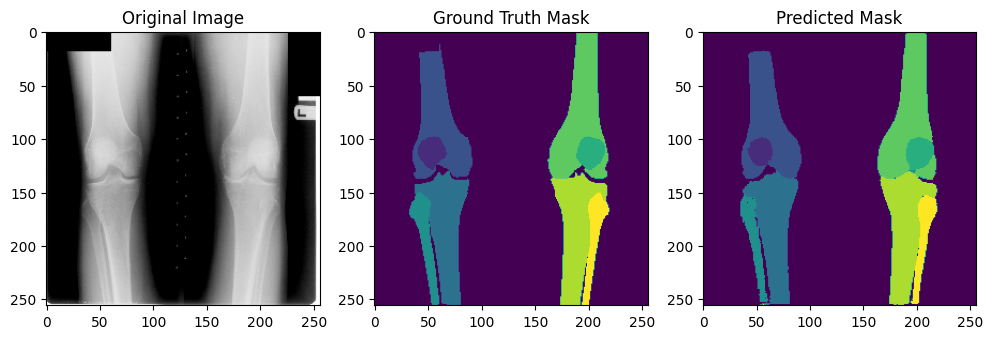

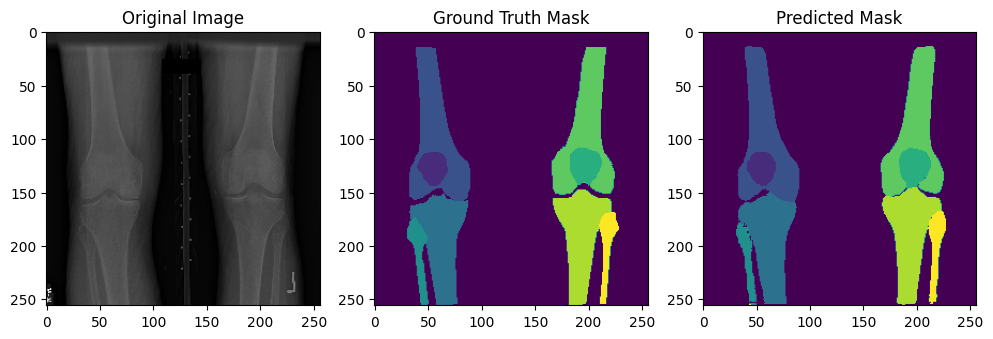

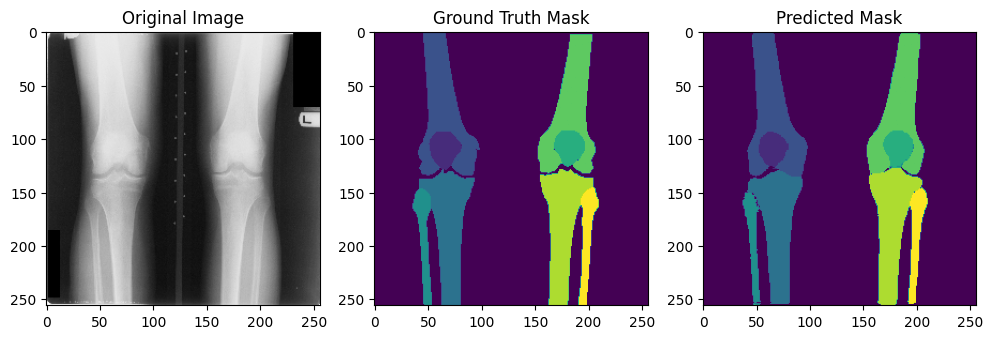

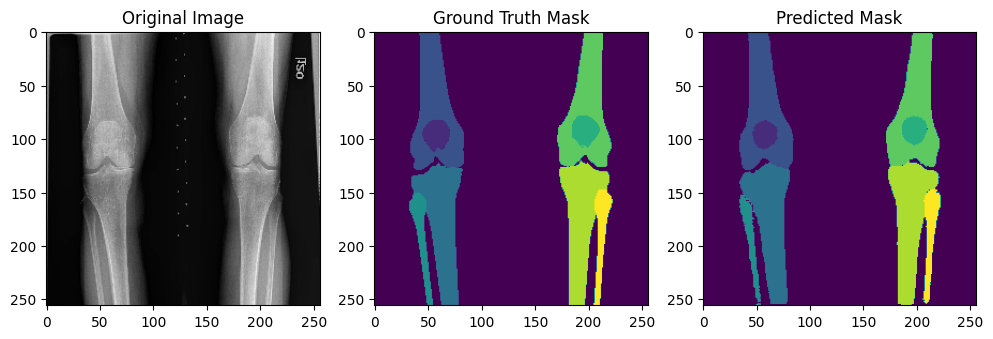

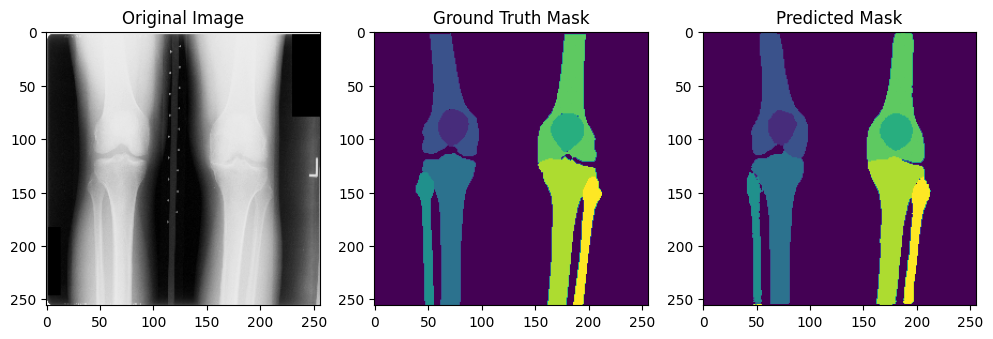

In [ ]:
import matplotlib.pyplot as plt


def visualize_samples(loader, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (images, masks, _) in enumerate(loader):
            if i >= 1:
                break

            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            predicted_masks = torch.argmax(outputs, dim=1)

            for j in range(images.shape[0]):
                plt.figure(figsize=(12, 4))


                plt.subplot(1, 3, 1)
                plt.title('Original Image')
                plt.imshow(images[j][0].cpu().numpy(), cmap='gray')


                plt.subplot(1, 3, 2)
                plt.title('Ground Truth Mask')
                plt.imshow(masks[j].argmax(dim=0).cpu().numpy(), cmap='viridis')


                plt.subplot(1, 3, 3)
                plt.title('Predicted Mask')
                plt.imshow(predicted_masks[j].cpu().numpy(), cmap='viridis')

                plt.show()


visualization_loader = DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)


visualize_samples(visualization_loader, num_samples=5)